# Ejercicio 5: Regresión lineal regularizada: sesgo y varianza
  ##     Agustín Jofré Millet

## 1. Regresión lineal regularizada

In [57]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt 
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
from scipy.io import loadmat



(12, 1) (12,)
(21, 1) (21,)
(21, 1) (21,)


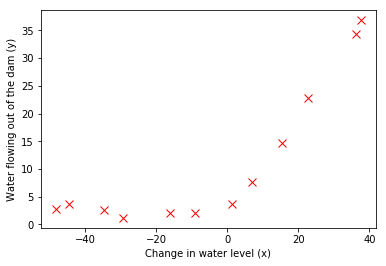

In [58]:
data = loadmat('ex5data1.mat')

X, y = data['X'], data['y'].ravel()
Xtest, ytest = data['Xtest'], data['ytest'].ravel()
Xval, yval = data['Xval'], data['yval'].ravel()

# m = numero de ejemplos de entrenamiento
m = X.shape[0]

# Plot training data
plt.plot(X, y, 'rx', ms=8)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)');

print (X.shape, y.shape)
print (Xval.shape, yval.shape)
print (Xtest.shape, ytest.shape)

In [146]:
def computeCost(X, y, theta):
    m = len(y)  
    diff = np.matmul(X, theta) - y
    J = 1 / (2 * m) * np.matmul(diff, diff)
    return J


def regLinealFuncCoste(X, y, theta, l ):
    
    m = len(y)  # number of training examples

    J = computeCost(X, y, theta)
    J += l / (2 * m) * np.matmul(theta[1:], theta[1:])
    grad = 1 / m * np.matmul(X.transpose(), np.matmul(X, theta) - y)
    grad[1:] += l / m * theta[1:]
    return J, grad
    

In [147]:
theta = np.array([1, 1])
l= 1

print (X.shape)
print (y.shape)
print (theta.shape)

J, grad = regLinealFuncCoste(np.hstack((np.ones((X.shape[0], 1)), X)),y.ravel(), theta, l)
print("Coste de : " ,J)
print ("Gradiente : ", grad)

(12, 1)
(12,)
(2,)
Coste de :  303.9931922202643
Gradiente :  [-15.30301567 598.25074417]


### Minimizamos para encontrar theta minimo

In [167]:

def min_lineal_reg(X, y, l):
   
    initial_theta = np.zeros(X.shape[1])

    costFunction = lambda t: regLinealFuncCoste(X, y, t, l)[0]
    gradFunction = lambda t: regLinealFuncCoste(X, y, t, l)[1]
    
    #metodo TNC
    options = {'maxiter': 200, 'disp': True}
    res = opt.minimize(costFunction, initial_theta, method='TNC', jac=gradFunction, options=options)
    theta = res.x
    return theta 

   

In [168]:
l = 0.0
X2 = np.hstack((np.ones((X.shape[0], 1)), X))
theta = min_lineal_reg(X2, y, 0)
theta

array([13.08790351,  0.36777923])

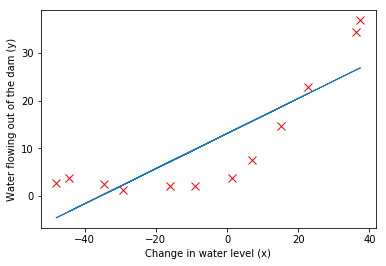

In [169]:
plt.plot(X, y, 'rx', ms=8)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.plot(X, np.dot(X2, theta), '-', lw=1);

## 2. Curvas de aprendizaje

In [170]:
def curvaAprendizaje(X, y, Xval, yval, l):
    m = X.shape[0]
    errro_entren = np.zeros(m)
    error_val = np.zeros(m)
    
    for i in range(1, m + 1):
        theta = min_lineal_reg(X[:i, ], y[:i, ], l)
        errro_entren[i - 1] = 1.0 / (2 * i) * np.sum(np.square(X[:i, ].dot(theta) - y[:i, ]))
        error_val[i - 1] = 1.0 / (2 * Xval.shape[0]) * np.sum(np.square(Xval.dot(theta) - yval))
        
    return errro_entren, error_val

# Ejemplos de entrenamiento	Error entrenado	Error validacion

  	1		0.000000	205.121096

  	2		0.000000	110.302641

  	3		3.286595	45.010231

  	4		2.842678	48.368910

  	5		13.154049	35.865165

  	6		19.443963	33.829962

  	7		20.098522	31.970986

  	8		18.172859	30.862446

  	9		22.609405	31.135998

  	10		23.261462	28.936207

  	11		24.317250	29.551432

  	12		22.373906	29.433818



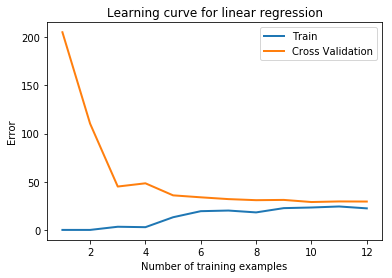

In [193]:
l = 0.0
error_entren, error_val = curvaAprendizaje(np.hstack((np.ones((m, 1)), X)), y, np.hstack((np.ones((Xval.shape[0], 1)), Xval)), yval, l)

plt.plot(np.arange(1, m+1), error_entren, np.arange(1, m+1), error_val, lw=2)
plt.title('Learning curve for linear regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of training examples')
plt.ylabel('Error')

print('# Ejemplos de entrenamiento\tError entrenado\tError validacion\n');
for i in range(0, m):
    print('  \t%d\t\t%f\t%f\n' % (i+1, error_entren[i], error_val[i]));

No hay ningun problema ni de sesgo ni varianza. 

## 3. Regresión polinomial

In [194]:
def polyCaracteristicas2 (X, p): 
    m = X.shape[0]
    Xpoly = np.zeros((m, p))
    Xpoly[:,0] = X[:,0]
    
    for ii in range(1,p):
        Xpoly[:,ii] = X[:,0]**(ii+1)
        
    return Xpoly

In [173]:

def polyCaracteristicas (X, p): 
    
    X_poly = X

    # Iterate over the polynomial power.
    for i in range(1, p):
        # Add the i-th power column in X.
        X_poly = np.column_stack((X_poly, np.power(X, i+1)))   
    
    return X_poly

In [174]:
def normalizar_caract(X):
    """ recibe una matriz de dimensión m x p y 
    devuelve: otra matriz de la misma dimensión 
    normalizada columna por columna a media 0 y 
    desviación estándar 1 """
    
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0, ddof=1)
    
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma  

In [175]:
def plotEntrenado(min_x, max_x, mu, sigma, theta, p):
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # valore de X nuevos de 1 hastq p
    x = np.arange(min_x-15, max_x+25, 0.05)
    x = np.reshape(x, (len(x), 1))
    
    # Map X and normalize
    X_poly = polyCaracteristicas(x, p)
    X_poly = (X_poly - mu) / sigma
    X_poly = np.hstack((np.ones((X_poly.shape[0], 1)), X_poly))
    
    plt.plot(x, np.dot(X_poly, theta), '-', lw=1)

In [176]:
p = 8

# X_poly caracteristicas polinomicas y  normalizar
X_poly = polyCaracteristicas (X, p)
print(X_poly.shape)
X_poly, mu, sigma = normalizar_caract(X_poly)
X_poly = np.hstack((np.ones((m, 1)), X_poly)) 

# X_poly_test normalizado, usando mu y sigma
X_poly_test = polyCaracteristicas(Xtest, p)
X_poly_test = (X_poly_test - mu) / sigma
X_poly_test = np.hstack((np.ones((X_poly_test.shape[0], 1)), X_poly_test))  

# X_poly_val normalizado usando mu y sigma
X_poly_val = polyCaracteristicas(Xval, p)
X_poly_val = (X_poly_val - mu) / sigma
X_poly_val = np.hstack((np.ones((X_poly_val.shape[0], 1)), X_poly_val))

print ("Ejemplo de entrenamiento normalizado :")
X_poly[0, :]

(12, 8)
Ejemplo de entrenamiento normalizado :


array([ 1.        , -0.36214078, -0.75508669,  0.18222588, -0.70618991,
        0.30661792, -0.59087767,  0.3445158 , -0.50848117])

In [177]:
def graficaEntre(X, y, X_poly, l):
    plt.figure()
    theta = min_lineal_reg(X_poly, y, l)

    plt.plot(X, y, 'rx', ms=8)

    plotEntrenado(np.min(X), np.max(X), mu, sigma, theta, p)

    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.title('Polynomial Regression Fit ($\lambda$ = %d)' % l)
    plt.ylim([-9, 60])
    plt.xlim([-60, 50])

In [195]:
def plotCurve(X_poly, y , X_poly_val, yval, l):
    plt.figure()

    error_entren, error_val = curvaAprendizaje(X_poly, y, X_poly_val, yval, l)
    
  
    plt.plot(np.arange(1, 1+m), error_entren, np.arange(1, 1+m), error_val)

    plt.title('Learning curve for linear regression ($\lambda$ = %d)' % l)
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend(['Train', 'Cross Validation'])
    
    print('Regresión polinomial (lambda = %f)\n\n' % l);
    print('# Ejemplos de entrenamiento\tError entrenado\tError validacion\n');
    for i in range(0, m):
        print('  \t%d\t\t%f\t%f\n' % (i+1, error_entren[i], error_val[i]))


Regresión polinomial (lambda = 0.000000)


# Ejemplos de entrenamiento	Error entrenado	Error validacion

  	1		0.000000	160.721900

  	2		0.000000	160.121510

  	3		0.000000	59.071638

  	4		0.000000	77.997853

  	5		0.000000	6.449344

  	6		0.000000	10.823300

  	7		0.000000	27.924263

  	8		0.000000	21.374358

  	9		0.000248	32.467706

  	10		0.034197	35.455832

  	11		0.033110	33.666303

  	12		0.030390	43.330995

Regresión polinomial (lambda = 1.000000)


# Ejemplos de entrenamiento	Error entrenado	Error validacion

  	1		0.000000	138.846778

  	2		0.045772	143.522872

  	3		2.911375	5.534711

  	4		1.499423	6.609891

  	5		1.199183	6.634075

  	6		0.924511	8.291988

  	7		1.540898	5.737173

  	8		1.422966	5.516472

  	9		1.553733	6.239737

  	10		1.441577	5.983020

  	11		1.308136	6.043643

  	12		2.076199	4.260603

Regresión polinomial (lambda = 100.000000)


# Ejemplos de entrenamiento	Error entrenado	Error validacion

  	1		0.000000	138.846777

  	2		0.114107	144.125230

  	3		

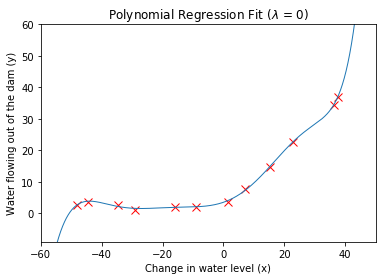

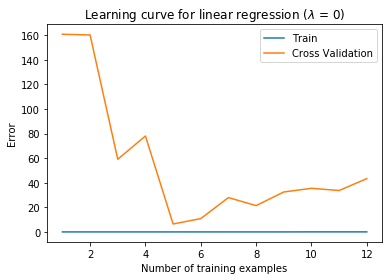

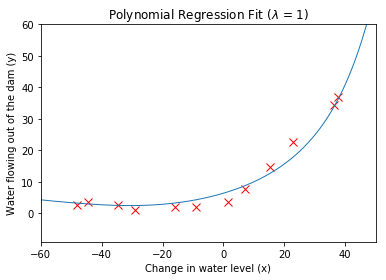

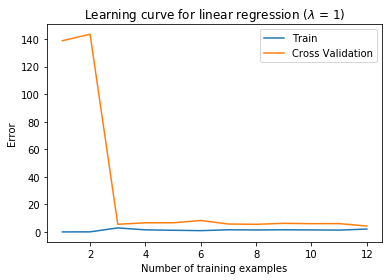

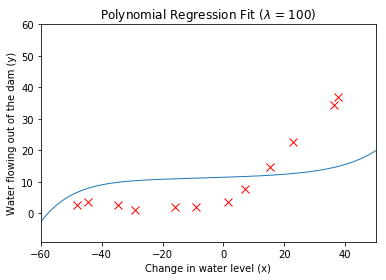

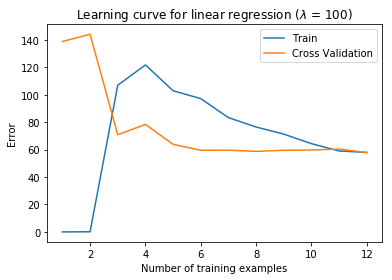

In [196]:
graficaEntre(X, y, X_poly, 0)
plotCurve(X_poly, y , X_poly_val, yval, 0)

graficaEntre(X, y, X_poly, 1)
plotCurve(X_poly, y , X_poly_val, yval, 1)

graficaEntre(X, y, X_poly, 100)
plotCurve(X_poly, y , X_poly_val, yval, 100)

##### Con lambda = 0 validacion y entrenamiento separados ( Varianza, sobreajuste)
##### Con lambda = 100 validacion y entrenamiento se acercan pero a un nivel muy alto. (BIas, poco ajustado)
##### Con lambda =1 no hay problamas ni de Bias o varianza

## 4. Selección del parámetro $\lambda$

In [198]:
def validacionCurvaLambda (X, y, Xval, yval):
    lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    error_train = []
    error_val = []

    for lambda_ in lambda_vec:
        theta = min_lineal_reg(X, y, lambda_)
        error_train.append(regLinealFuncCoste(X, y, theta, 0)[0])
        error_val.append(regLinealFuncCoste(Xval, yval, theta, 0)[0])

    return lambda_vec, error_train, error_val

Text(0,0.5,'Error')

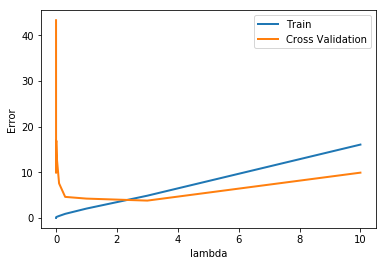

In [224]:
lambda_vec, error_train, error_val = validacionCurvaLambda(X_poly, y, X_poly_val, yval)

plt.plot(lambda_vec, error_train, '-', lambda_vec, error_val, '-', lw=2)
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('lambda')
plt.ylabel('Error')



In [228]:
print ('# lambda / Error entrenamiento / VErro Validacion')
for i in range(len(lambda_vec)):
    print ('  {0:<8} {1:<13.8f} {2:<.8f}'.format(lambda_vec[i], error_train[i], error_val[i]))

# lambda / Error entrenamiento / VErro Validacion
  0        0.03039016    43.33099471
  0.001    0.11284625    9.89652369
  0.003    0.17094268    16.40160379
  0.01     0.22146276    16.94421966
  0.03     0.28186315    12.82889252
  0.1      0.45931743    7.58702580
  0.3      0.92178161    4.63676039
  1        2.07619931    4.26060291
  3        4.90137313    3.82292689
  10       16.09227272   9.94555423


In [229]:
l = 3

theta = min_lineal_reg(X_poly, y, l)
h_test = np.dot( X_poly_test, theta)
test_error = np.sum(np.square( h_test - ytest ))/(2*Xtest.shape[0])
print(f'test error = {test_error}')

test error = 3.859905520108477
